# Federated learning with tensorflow


In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def load_dataset(nb_clients):

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # x_train = x_train[:10000]
    # y_train = y_train[:10000]
    
    assert x_train.shape == (60000, 28, 28)
    assert x_test.shape == (10000, 28, 28)
    assert y_train.shape == (60000,)
    assert y_test.shape == (10000,)
    
    train, valid, test = [], [], tf.data.Dataset.from_tensor_slices((np.array([]),np.array([])))
    prop = 0.25
    length = x_train.shape[0]//nb_clients
    
    for i in range(nb_clients):
        choice = np.random.choice(range(x_train.shape[0]), size=(length,), replace=False)    
        ind = np.zeros(x_train.shape[0], dtype=bool)
        ind[choice] = True
        rest = ~ind
        
        tmpx = x_train[ind]
        tmpy = y_train[ind]
        
        size = int(tmpx.shape[0]*(1-prop))
    
        train_data = tf.data.Dataset.from_tensor_slices((tmpx[:size],tmpy[:size]))
        valid_data = tf.data.Dataset.from_tensor_slices((tmpx[size+1:],tmpy[size+1:]))

        # for comparison with QCNN
        train_data = train_data.take(1000)
        valid_data = valid_data.take(400)
    
        train_data = train_data.batch(32)
        valid_data = valid_data.batch(32)
        
        train.append(train_data)
        valid.append(valid_data)
        
    test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
    test = test.take(200)
    test = test.batch(32)
        
    return train, valid, test

In [4]:
train, valid, test = load_dataset(1)
type(test)

11501568/11490434 [==============================] - 0s 0us/step


tensorflow.python.data.ops.dataset_ops.BatchDataset

In [5]:
def setup_model():
    model = models.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(28,28,1)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))
    
    # print(model.summary())

    return model

In [6]:
def train_model(model,train_dataset, valid_dataset,epochs):
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
                  
    history = model.fit(train_dataset, epochs=epochs, verbose=2, validation_data=valid_dataset,
                        callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                            patience=1, min_lr=0.00001, verbose=0)])

    return model

In [7]:
def average_models(models):
    print('averaging')
    new = np.array(models[0].get_weights())
    for model in models[1:]: new = new + np.array(model.get_weights())
    
    new = new/np.array([len(models)])
        
    new_model = setup_model()
    new_model.set_weights(new)
    
    return new_model

In [8]:
def main():
    nb_clients = 3
    
    datasets = load_dataset_unbalanced(nb_clients)
    
    models = []
    for _ in range(nb_clients): models.append(setup_model())
    
    eval1 = []
    eval2 = []
    eval3 = []
        
    for k in range(5):
        for i in range(nb_clients): models[i] = train_model(models[i],datasets[0][i],datasets[1][i],5)
        eval3.append(models[0].evaluate(datasets[1][0],verbose=0)[1])
        eval1.append(models[0].evaluate(datasets[2],verbose=0)[1])
        avg_model = average_models(models)
        for i in range(nb_clients): models[i].set_weights(avg_model.get_weights())
        eval2.append(models[0].evaluate(datasets[2],verbose=0)[1])
            
    plt.plot(eval1,label='local accuracy')
    plt.plot(eval2,label='global accuracy')
    plt.xlabel('federation iterations')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

    plt.plot(eval3,label='local accuracy')
    plt.xlabel('federation iterations')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.show()
            
    return models

In [10]:
def create_prob(n=10):
    p = np.random.randn(n)**2
    return p/np.sum(p)

def load_dataset_unbalanced(nb_clients):

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # x_train = x_train[:10000]
    # y_train = y_train[:10000]
    
    assert x_train.shape == (60000, 28, 28)
    assert x_test.shape == (10000, 28, 28)
    assert y_train.shape == (60000,)
    assert y_test.shape == (10000,)
    
    train, valid, test = [], [], tf.data.Dataset.from_tensor_slices((np.array([]),np.array([])))
    prop = 0.25
    length = x_train.shape[0]//nb_clients
    
    for i in range(nb_clients):
        choice = np.random.choice(range(x_train.shape[0]), size=(length,), replace=False)    
        ind = np.zeros(x_train.shape[0], dtype=bool)
        ind[choice] = True
        rest = ~ind
        
        tmpx = x_train[ind]
        tmpy = y_train[ind]
        
        size = int(tmpx.shape[0]*(1-prop))
    
        train_data = tf.data.Dataset.from_tensor_slices((tmpx[:size],tmpy[:size]))
        valid_data = tf.data.Dataset.from_tensor_slices((tmpx[size+1:],tmpy[size+1:]))
    
        train_data = train_data.batch(32)
        valid_data = valid_data.batch(32)
        
        train.append(train_data)
        valid.append(valid_data)
        
    test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
    test = test.batch(32)
        
    return train, valid, test

Epoch 1/5
469/469 - 9s - loss: 0.5893 - accuracy: 0.8203 - val_loss: 0.2588 - val_accuracy: 0.9240 - lr: 0.0010 - 9s/epoch - 19ms/step
Epoch 2/5
469/469 - 8s - loss: 0.2015 - accuracy: 0.9407 - val_loss: 0.1900 - val_accuracy: 0.9432 - lr: 0.0010 - 8s/epoch - 16ms/step
Epoch 3/5
469/469 - 8s - loss: 0.1479 - accuracy: 0.9549 - val_loss: 0.1430 - val_accuracy: 0.9582 - lr: 0.0010 - 8s/epoch - 17ms/step
Epoch 4/5
469/469 - 8s - loss: 0.1165 - accuracy: 0.9642 - val_loss: 0.1149 - val_accuracy: 0.9666 - lr: 0.0010 - 8s/epoch - 16ms/step
Epoch 5/5
469/469 - 8s - loss: 0.0944 - accuracy: 0.9717 - val_loss: 0.1000 - val_accuracy: 0.9706 - lr: 0.0010 - 8s/epoch - 17ms/step
Epoch 1/5
469/469 - 9s - loss: 0.6291 - accuracy: 0.8038 - val_loss: 0.2475 - val_accuracy: 0.9270 - lr: 0.0010 - 9s/epoch - 18ms/step
Epoch 2/5
469/469 - 8s - loss: 0.2014 - accuracy: 0.9399 - val_loss: 0.1759 - val_accuracy: 0.9450 - lr: 0.0010 - 8s/epoch - 18ms/step
Epoch 3/5
469/469 - 8s - loss: 0.1412 - accuracy: 0.957

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/5
469/469 - 8s - loss: 0.3775 - accuracy: 0.8925 - val_loss: 0.1803 - val_accuracy: 0.9488 - lr: 0.0010 - 8s/epoch - 18ms/step
Epoch 2/5
469/469 - 8s - loss: 0.1574 - accuracy: 0.9515 - val_loss: 0.1447 - val_accuracy: 0.9566 - lr: 0.0010 - 8s/epoch - 17ms/step
Epoch 3/5
469/469 - 8s - loss: 0.1206 - accuracy: 0.9627 - val_loss: 0.1269 - val_accuracy: 0.9614 - lr: 0.0010 - 8s/epoch - 16ms/step
Epoch 4/5
469/469 - 8s - loss: 0.1002 - accuracy: 0.9683 - val_loss: 0.1155 - val_accuracy: 0.9654 - lr: 0.0010 - 8s/epoch - 17ms/step
Epoch 5/5
469/469 - 8s - loss: 0.0858 - accuracy: 0.9731 - val_loss: 0.1091 - val_accuracy: 0.9690 - lr: 0.0010 - 8s/epoch - 16ms/step
Epoch 1/5
469/469 - 8s - loss: 0.3692 - accuracy: 0.8965 - val_loss: 0.1908 - val_accuracy: 0.9434 - lr: 0.0010 - 8s/epoch - 18ms/step
Epoch 2/5
469/469 - 8s - loss: 0.1500 - accuracy: 0.9551 - val_loss: 0.1616 - val_accuracy: 0.9510 - lr: 0.0010 - 8s/epoch - 17ms/step
Epoch 3/5
469/469 - 8s - loss: 0.1162 - accuracy: 0.963

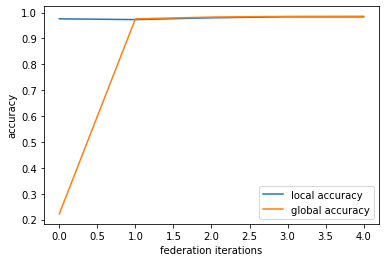

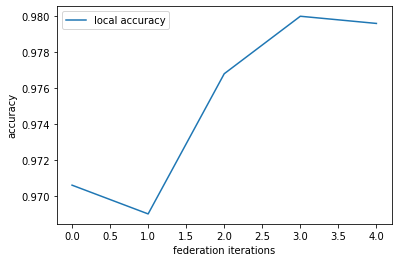

In [11]:
main()